In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, kruskal
from scipy.fft import fft, ifft
import pickle
from scipy.signal import butter, filtfilt, hilbert, find_peaks
from pathlib import Path


c:\Users\blanc\miniconda3\envs\adaexam\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


#### Load data and Extract Phase using Hilbert Decomposition

In [4]:
with open("../Data/animals_data_processed.pkl", "rb") as f:
        data = pickle.load(f)

breath_dict = data["breath_dict"]
breath_filt_dict = data["breath_filt_dict"]
valve_dict = data["valve_dict"]
pulse_dict = data["pulse_dict"]
calcium_dict = data["calcium_dict"]
ca_interp_dict = data["ca_interp_dict"]
phase_hilbert_dict = data["phase_hilbert_dict"]
phase_peaks_dict = data["phase_peaks_dict"]
t_breath = data["t_breath"]
t_pulse = data["t_valve"]
t_calcium = data["t_calcium"]
animals = data["animals"]

In [ ]:
#breath_dict, breath_filt_dict, valve_dict, pulse_dict, calcium_dict, ca_interp_dict, phase_hilbert_dict, phase_peaks_dict, t_breath, t_pulse, t_calcium, animals = load_dataset()

c:\Users\blanc\OneDrive - Harvard University\Documents\sparseness\sparseness


KeyError: 'breath'

#### Breath Signal Filtered

KeyError: 0

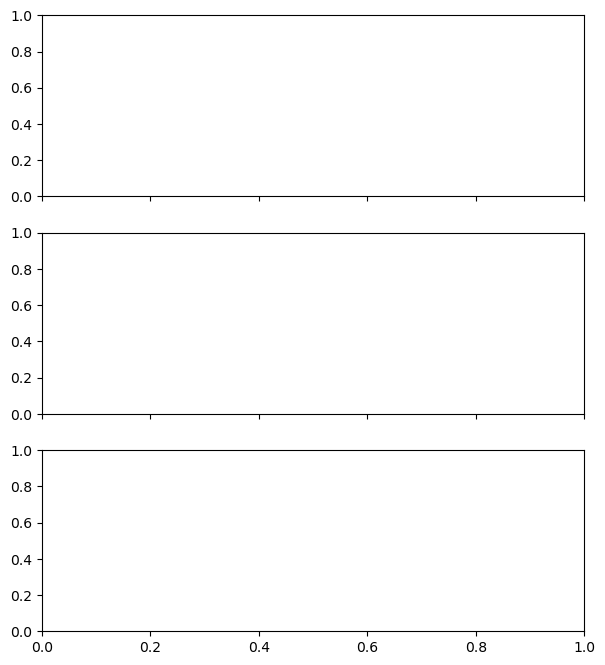

In [5]:
fig, axs = plt.subplots(nrows=3, figsize=(7, 8), sharex=True)

for i, key in enumerate(breath_dict.keys()):
    axs[i].plot(t_breath[i], breath_dict[key], label=f'Noisy signal for {key}')
    axs[i].plot(t_breath[i], breath_filt_dict[key], label=f'Filtered signal for {key}')
    xmin, xmax = 20, 25
    axs[i].set_xlim(xmin, xmax)

    axs[i].set_xlabel('Time (seconds)')
    axs[i].set_ylabel('Signal Amplitude')
    axs[i].grid(True)
    axs[i].legend(loc='upper left')

plt.tight_layout()
plt.show()

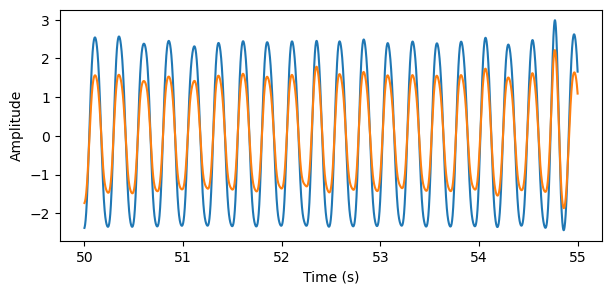

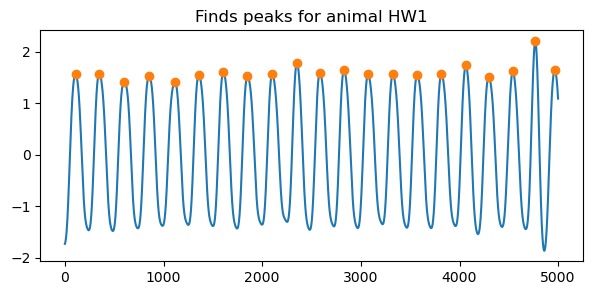

In [4]:
from scipy.signal import butter, filtfilt, find_peaks

fh = 3
fl = 10
fs=1000

b_hp, a_hp = butter(3, fh / (fs / 2), btype='high')
breath_filtered = filtfilt(b_hp, a_hp, breath_filt_dict['HW1'])

# Low-pass smoothing filter
b_lp, a_lp = butter(3, fl / (fs / 2), btype='low')
breath_smoothed = filtfilt(b_lp, a_lp, breath_filtered)

#breath_norm = (breath_smoothed - np.mean(breath_smoothed)) / np.std(breath_smoothed)
breath_norm = (breath_filtered - np.mean(breath_filtered)) / np.std(breath_filtered)

plt.figure(figsize=(7, 3))
plt.plot(t_breath[0][50000:55000], breath_filt_dict['HW1'][50000:55000], label=f'Signal for HW1')
plt.plot(t_breath[0][50000:55000], breath_norm[50000:55000], label=f'Filtered signal for HW1')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

min_dist=120
min_samples = int((min_dist / 1000) * fs)  # Convert minDist from ms to samples
peaks, _ = find_peaks(breath_norm[50000:55000], distance=min_samples)
plt.figure(figsize=(7, 3))  
plt.plot(breath_norm[50000:55000])
plt.plot(peaks, breath_norm[50000:55000][peaks], "o")
plt.title(f'Finds peaks for animal HW1')
plt.show()

#### Alignment of Breath, Pulse and Calcium Imaging

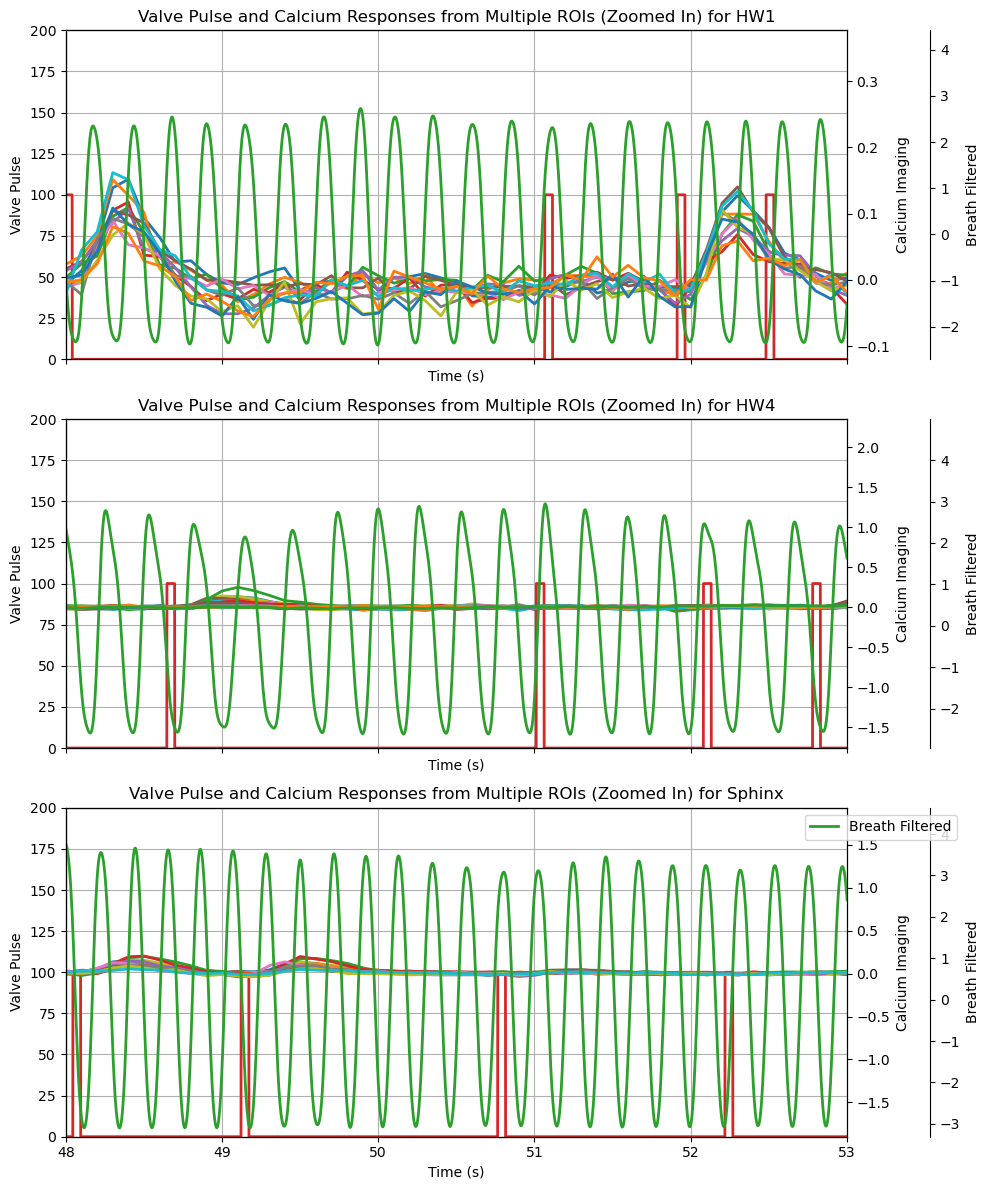

In [5]:
fig, axs = plt.subplots(nrows=len(calcium_dict.keys()), figsize=(10, 12), sharex=True)

for i, key in enumerate(calcium_dict.keys()):
    axs[i].plot(t_breath[i], valve_dict[key], color='tab:red', linewidth=2, label='Valve Pulse')
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Valve Pulse')
    axs[i].set_xlim(48, 53)
    valve_min, valve_max = np.min(valve_dict[key]), np.max(valve_dict[key])
    axs[i].set_ylim(valve_min, valve_max)
    axs[i].tick_params(axis='y')

    ax2 = axs[i].twinx()
    calcium_min, calcium_max = np.inf, -np.inf  
    for j in range(len(ca_interp_dict[key].columns)):
        min_val, max_val = np.min(ca_interp_dict[key].iloc[:, j]), np.max(ca_interp_dict[key].iloc[:, j])
        calcium_min = min(calcium_min, min_val)
        calcium_max = max(calcium_max, max_val)
        ax2.plot(t_breath[i], ca_interp_dict[key].iloc[:, j], linewidth=2, label=f'ROI {j+1}')
    ax2.set_ylim(calcium_min, calcium_max)
    ax2.set_ylabel('Calcium Imaging')
    ax2.tick_params(axis='y')

    ax3 = axs[i].twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.plot(t_breath[i], breath_filt_dict[key], color='tab:green', linewidth=2, label='Breath Filtered')
    breath_min, breath_max = np.min(breath_filt_dict[key]), np.max(breath_filt_dict[key])
    ax3.set_ylim(breath_min, breath_max)
    ax3.set_ylabel('Breath Filtered')
    ax3.tick_params(axis='y')

    axs[i].set_title(f'Valve Pulse and Calcium Responses from Multiple ROIs (Zoomed In) for {key}')
    axs[i].grid(True)

fig.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.show()

#### Align Breath Flow and Breath Phase

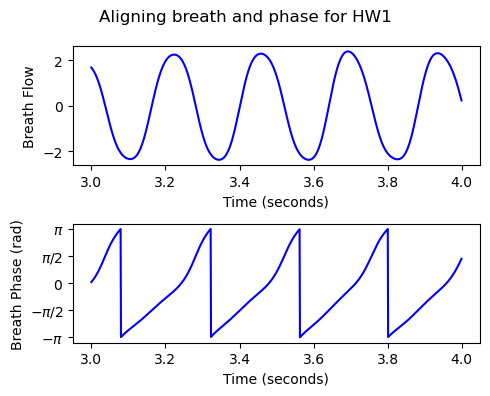

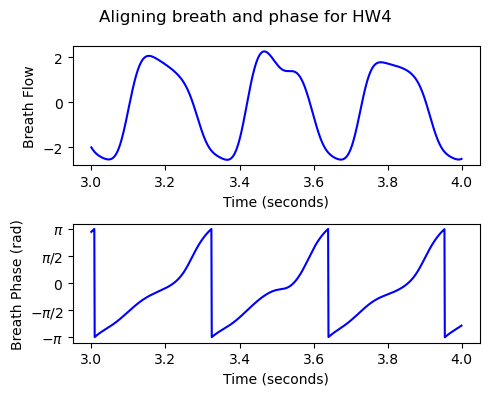

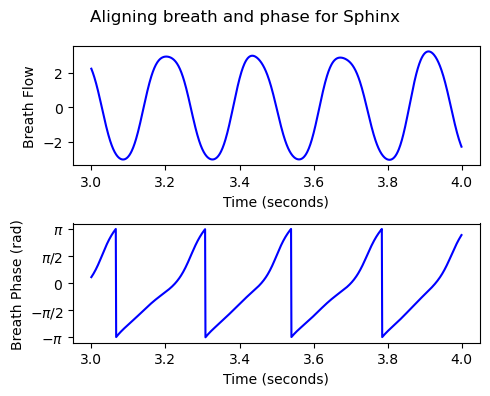

In [6]:
def align_flow_phase(instantaneous_phase, breath_flow, t_breath, animal):

    fig, (ax2, ax3) = plt.subplots(nrows=2, figsize=(5, 4), gridspec_kw={'height_ratios': [1, 1]})

    ax2.plot(t_breath[3000:4000], breath_flow[3000:4000], label='Breath Flow', color='blue')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Breath Flow')

    ax3.plot(t_breath[3000:4000], instantaneous_phase[3000:4000], label='Breath Phase', color='blue')
    ax3.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    ax3.set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])    
    ax3.set_xlabel('Time (seconds)')
    ax3.set_ylabel('Breath Phase (rad)')

    fig.suptitle(f"Aligning breath and phase for {animal}")

    plt.tight_layout()
    plt.show()

num_bins = 10  
phase_bins = np.linspace(-np.pi, np.pi, num_bins + 1)

align_flow_phase(instantaneous_phase=phase_hilbert_dict['HW1'], breath_flow=breath_filt_dict['HW1'], t_breath=t_breath[0], animal="HW1")
align_flow_phase(instantaneous_phase=phase_hilbert_dict['HW4'], breath_flow=breath_filt_dict['HW4'], t_breath=t_breath[1], animal="HW4")
align_flow_phase(instantaneous_phase=phase_hilbert_dict['Sphinx'], breath_flow=breath_filt_dict['Sphinx'], t_breath=t_breath[2], animal="Sphinx")

#### Compare Hilbert Decomposition with 'Find Peaks' Phase Decomposition 

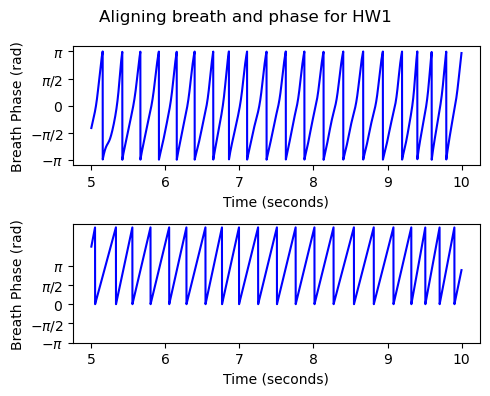

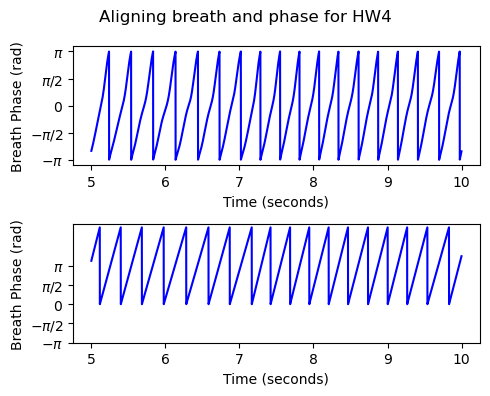

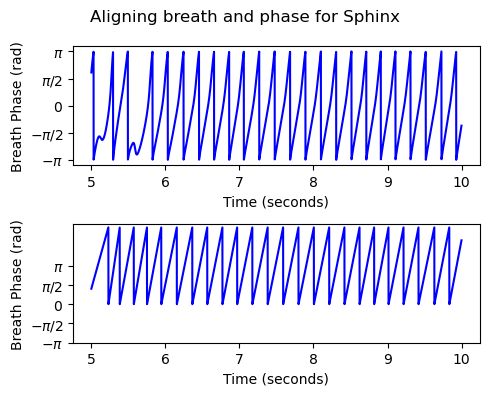

In [6]:
for i, key in enumerate(phase_hilbert_dict.keys()):
    fig, (ax2, ax3) = plt.subplots(nrows=2, figsize=(5, 4), gridspec_kw={'height_ratios': [1, 1]})
    ax2.plot(t_breath[i][5000:10000], phase_hilbert_dict[key][5000:10000], label='Breath Phase (hilbert)', color='blue')
    ax2.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    ax2.set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$',])    
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Breath Phase (rad)')
    ax3.plot(t_breath[i][5000:10000], phase_peaks_dict[key][5000:10000], label='Breath Phase (peaks)', color='blue')
    ax3.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    ax3.set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$',])    
    ax3.set_xlabel('Time (seconds)')
    ax3.set_ylabel('Breath Phase (rad)')
    fig.suptitle(f"Aligning breath and phase for {key}")
    plt.tight_layout()
    plt.show()

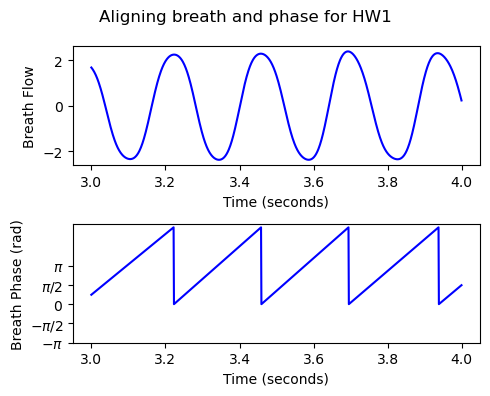

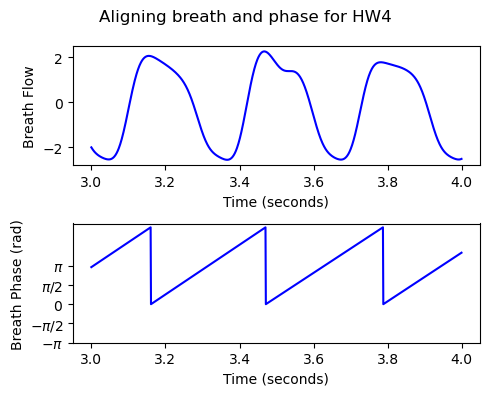

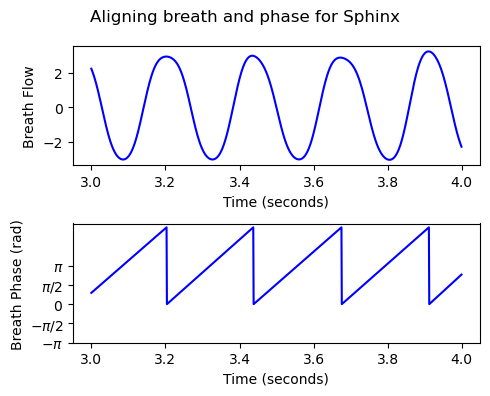

In [7]:

align_flow_phase(instantaneous_phase=phase_peaks_dict['HW1'], breath_flow=breath_filt_dict['HW1'], t_breath=t_breath[0], animal="HW1")
align_flow_phase(instantaneous_phase=phase_peaks_dict['HW4'], breath_flow=breath_filt_dict['HW4'], t_breath=t_breath[1], animal="HW4")
align_flow_phase(instantaneous_phase=phase_peaks_dict['Sphinx'], breath_flow=breath_filt_dict['Sphinx'], t_breath=t_breath[2], animal="Sphinx")

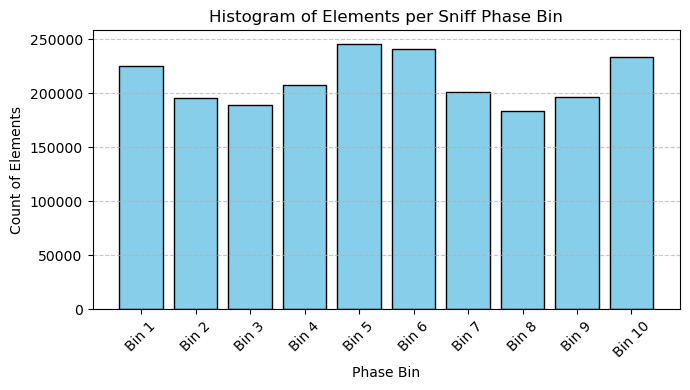

In [7]:
def plot_bin_counts(phase, num_bins, title="Histogram of Elements per Sniff Phase Bin"):
    phase_bins = np.linspace(-np.pi, np.pi, num_bins + 1)
    bin_indices = np.digitize(phase, phase_bins) - 1  
    bin_counts = np.bincount(bin_indices, minlength=num_bins)
    
    # Plot the histogram
    plt.figure(figsize=(7, 4))
    plt.bar(range(num_bins), bin_counts, width=0.8, color='skyblue', edgecolor='black')
    plt.xticks(range(num_bins), labels=[f"Bin {i+1}" for i in range(num_bins)], rotation=45)
    plt.xlabel("Phase Bin")
    plt.ylabel("Count of Elements")
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_bin_counts(phase_hilbert_dict['HW1'], 10)

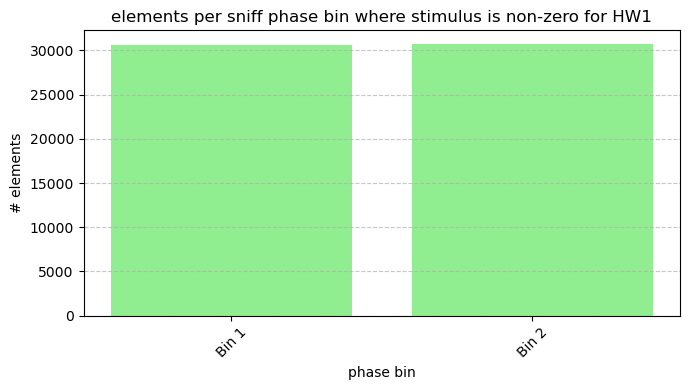

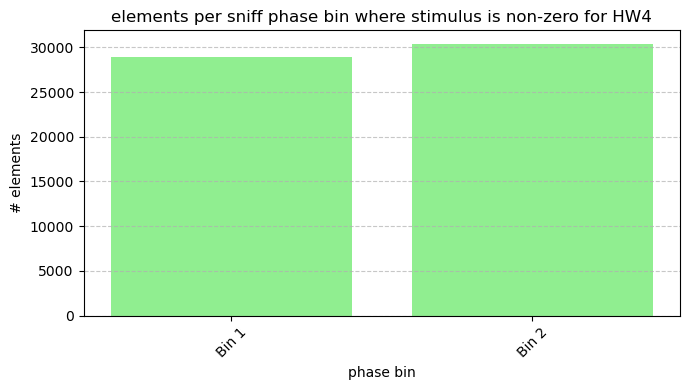

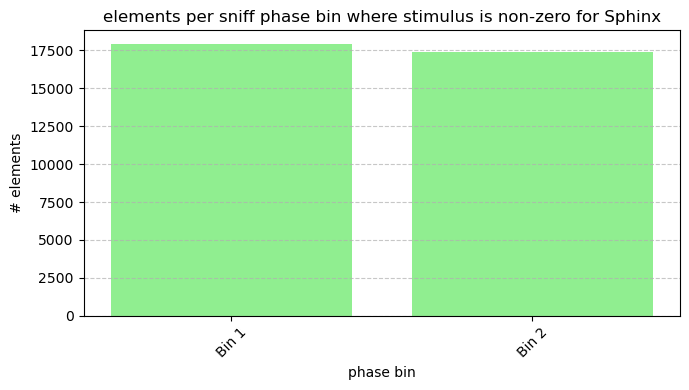

In [8]:
def plot_nonzero_stim_bin_counts(stim, breath, num_bins, title="elements per sniff phase bin where stimulus is non-zero"):
    nonzero_indices = stim != 0
    breath_nonzero = breath[nonzero_indices]

    phase_bins = np.linspace(0, 2*np.pi, num_bins + 1)
    bin_indices = np.digitize(breath_nonzero, phase_bins) - 1 
    bin_counts = np.bincount(bin_indices, minlength=num_bins)
    
    plt.figure(figsize=(7, 4))
    plt.bar(range(num_bins), bin_counts, width=0.8, color='lightgreen')
    plt.xticks(range(num_bins), labels=[f"Bin {i+1}" for i in range(num_bins)], rotation=45)
    plt.xlabel("phase bin")
    plt.ylabel("# elements")
    plt.title(f'{title} for {key}')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

for i,key in enumerate(valve_dict.keys()):
    plot_nonzero_stim_bin_counts(valve_dict[key], phase_peaks_dict[key], 2)


#### Average Calcium Response per Sniff Phase

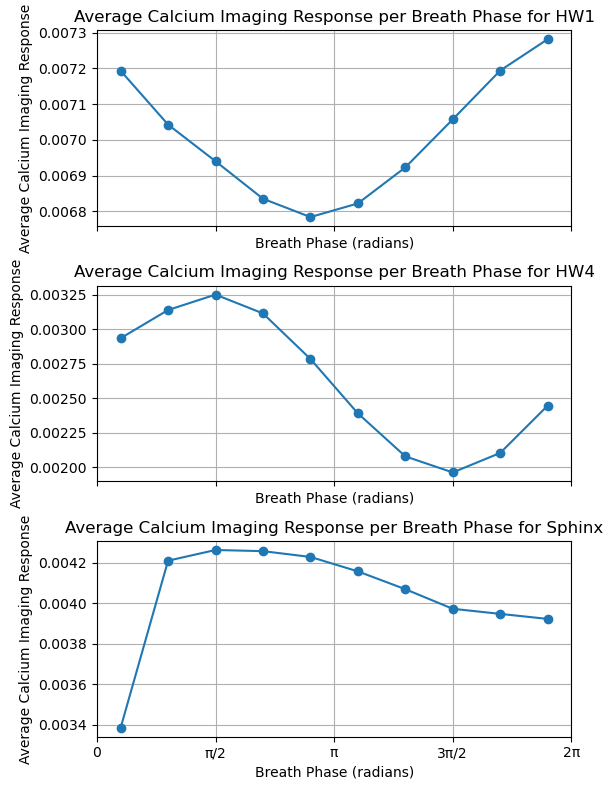

In [13]:
fig, axs = plt.subplots(nrows=3, figsize=(6, 8), sharex=True)

# Bin the breath phase data
num_bins = 10  
phase_bins = np.linspace(0, 2*np.pi, num_bins + 1)

for i, key in enumerate(breath_dict.keys()):

    average_calcium_response = ca_interp_dict[key].mean(axis=1)  # Row-wise mean
    avg_calcium_per_phase = np.zeros(num_bins)

    # Mean calcium response for each phase bin
    for j in range(num_bins):
        in_bin = (phase_peaks_dict[key] >= phase_bins[j]) & (phase_peaks_dict[key] < phase_bins[j + 1])
        
        if np.any(in_bin):  
            avg_calcium_per_phase[j] = average_calcium_response[in_bin].mean()

    phase_bin_centers = (phase_bins[:-1] + phase_bins[1:]) / 2

    axs[i].plot(phase_bin_centers, avg_calcium_per_phase, marker='o', linestyle='-')
    axs[i].set_xlabel("Breath Phase (radians)")
    axs[i].set_ylabel("Average Calcium Imaging Response")
    axs[i].set_xticks([0, np.pi / 2, np.pi, 3*np.pi / 2, 2*np.pi])
    axs[i].set_xticklabels(['0', 'π/2', 'π', '3π/2', '2π'])

    axs[i].set_title(f'Average Calcium Imaging Response per Breath Phase for {key}')
    axs[i].grid()


fig.tight_layout()
plt.show()

- Phase Peaks: sharp increase in the average calcium response right after 𝜋/2 --> mmay correspond to a specific phase of the breathing cycle
Correlation between ca response and a particular part of either inhalation (based on the graph phase abd breath rhythm as a function of time plotted before)
- Calcium response less responsive during some parts of the cycle
- Periodic sensitivity to the breath phase, with calcium response not uniform across the cycle

Hypotheses Based on the Observations
- Phase-locked Neuronal Activity: neural responsiveness fluctuates with the breath cycle
- Response to Specific Breathing Events: olfactory neurons may be tuned to detect parts of the cycle more intensely

### Long-Term Adaptation Study

#### Evolution of the ca peaks over time

- look at the amplitude of the signals over time: isolate the peaks and plot them (scatter plot) as a function of time (in other words plot the size of the peak as a function of the time it occurred at)

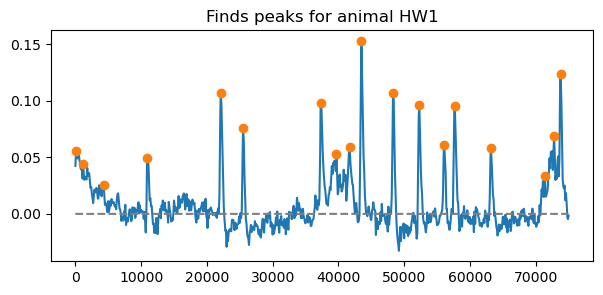

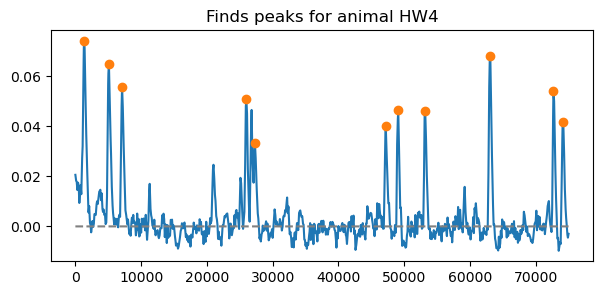

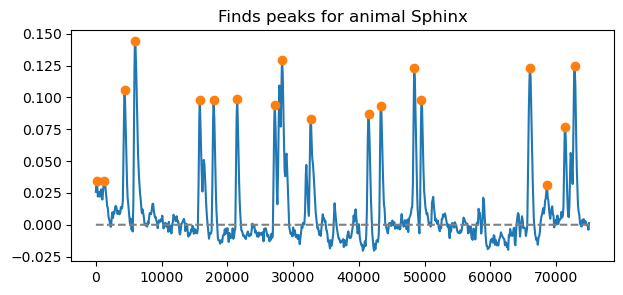

In [14]:
from scipy.signal import find_peaks

all_peaks = []

for i, key in enumerate(ca_interp_dict.keys()):
    ca = ca_interp_dict[key].mean(axis=1).to_numpy()
    peaks, _ = find_peaks(ca, height = 0.025,distance=1000)

    ca_sub = ca_interp_dict[key].mean(axis=1).to_numpy()[0:75000]
    peaks_sub, _ = find_peaks(ca_sub, height = 0.025,distance=1000)
    plt.figure(figsize=(7, 3))  
    plt.plot(ca_sub)
    plt.plot(peaks_sub, ca_sub[peaks_sub], "o")
    plt.plot(np.zeros_like(ca_sub), "--", color="gray")
    plt.title(f'Finds peaks for animal {key}')
    plt.show()

    all_peaks.append(peaks)

peaks_dict = dict(zip(animals, all_peaks))

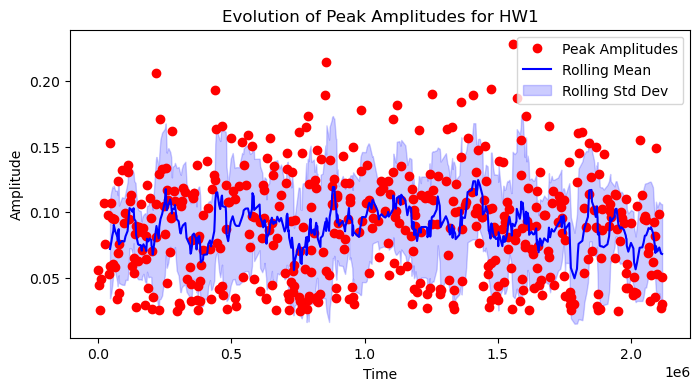

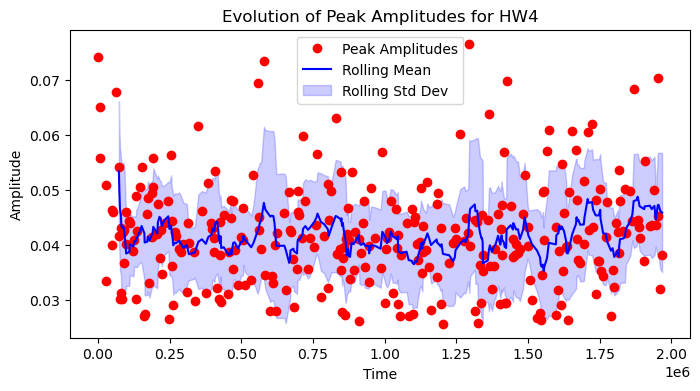

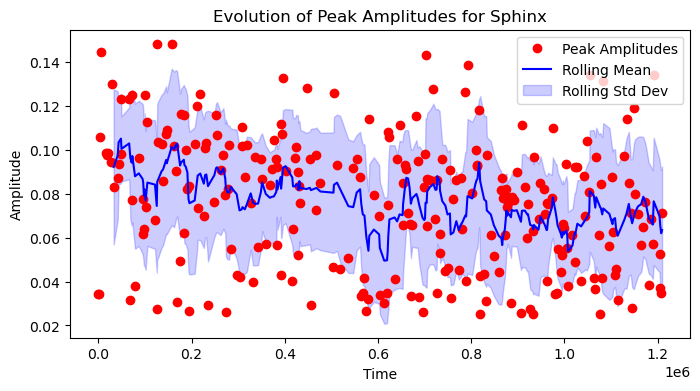

In [15]:
    
for i, key in enumerate(peaks_dict.keys()):
    peaks = peaks_dict[key]
    ca = ca_interp_dict[key].mean(axis=1).to_numpy()
    peak_df = pd.DataFrame({'Time':peaks, 'Amplitude': ca[peaks]})

    window_size = 10 
    peak_df['Rolling_Mean'] = peak_df['Amplitude'].rolling(window=window_size).mean()
    peak_df['Rolling_Std'] = peak_df['Amplitude'].rolling(window=window_size).std()

    plt.figure(figsize=(8, 4))
    plt.plot(peak_df['Time'], peak_df['Amplitude'], 'ro', label='Peak Amplitudes')
    plt.plot(peak_df['Time'], peak_df['Rolling_Mean'], 'b-', label='Rolling Mean')
    plt.fill_between(
        peak_df['Time'],
        peak_df['Rolling_Mean'] - peak_df['Rolling_Std'],
        peak_df['Rolling_Mean'] + peak_df['Rolling_Std'],
        color='blue', alpha=0.2, label='Rolling Std Dev'
    )
    plt.title(f'Evolution of Peak Amplitudes for {key}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

In [16]:
from scipy.stats import f_oneway

for i,key in enumerate(peaks_dict.keys()):
    num_intervals = 3
    interval_size = len(peaks_dict[key]) // num_intervals
    ca = ca_interp_dict[key].mean(axis=1).to_numpy()
    groups = [ca[peaks_dict[key]][i * interval_size:(i + 1) * interval_size] for i in range(num_intervals)]

    # Perform ANOVA
    f_stat, p_value = f_oneway(*groups)
    print(f"ANOVA results for {key}: F-statistic = {f_stat}, p-value = {p_value}")

    if p_value < 0.05:
        print("Significant difference in peak amplitudes across intervals.")
    else:
        print("No significant difference in peak amplitudes across intervals.")


ANOVA results for HW1: F-statistic = 1.4264650817344806, p-value = 0.24119192990179286
No significant difference in peak amplitudes across intervals.
ANOVA results for HW4: F-statistic = 0.6613251513252292, p-value = 0.5169102921895681
No significant difference in peak amplitudes across intervals.
ANOVA results for Sphinx: F-statistic = 8.481399741625447, p-value = 0.00027158849853344436
Significant difference in peak amplitudes across intervals.


#### Evolution of the reaction time

Average response time to pulse over the experiment (the interval between the pulse and the response)

In [17]:
def extract_reactive_times(peaks, pulse_signal, window_size=1000):
    pulse_indices = np.where(pulse_signal != 0)[0]

    reactive_times = []

    for peak in peaks:
        window_start = max(0, peak - window_size)

        idx = np.searchsorted(pulse_indices, peak) - 1 

        while idx >= 0 and pulse_indices[idx] < window_start:
            window_start = max(0, window_start - window_size)
            idx -= 1

        if idx >= 0:
            reactive_times.append(pulse_indices[idx])
        else:
            reactive_times.append(None)

    return reactive_times

In [18]:
diff_data = []
for i, key in enumerate(peaks_dict.keys()):
    reactive_times = extract_reactive_times(peaks_dict[key], valve_dict[key])

    differences = [
        peak - reactive_time if reactive_time is not None else None
        for peak, reactive_time in zip(peaks_dict[key], reactive_times)
    ]

    data = {
        'Peaks': peaks_dict[key],
        'Reactive_Times': reactive_times,
        'Difference': differences
    }

    diff_data.append(differences)

diff_dict= dict(zip(animals, diff_data))


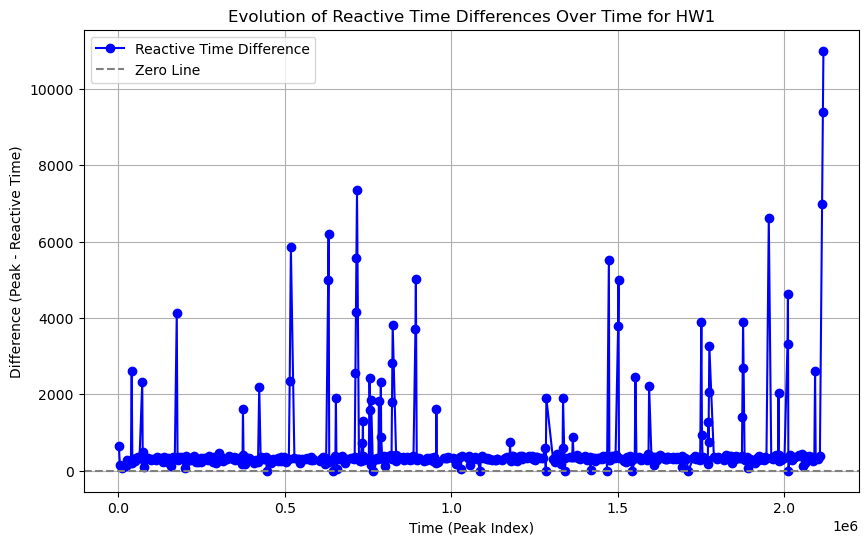

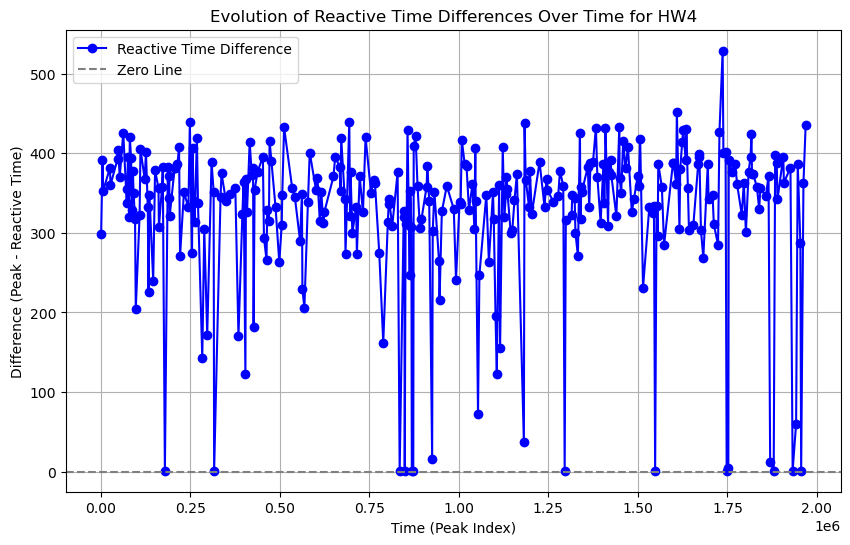

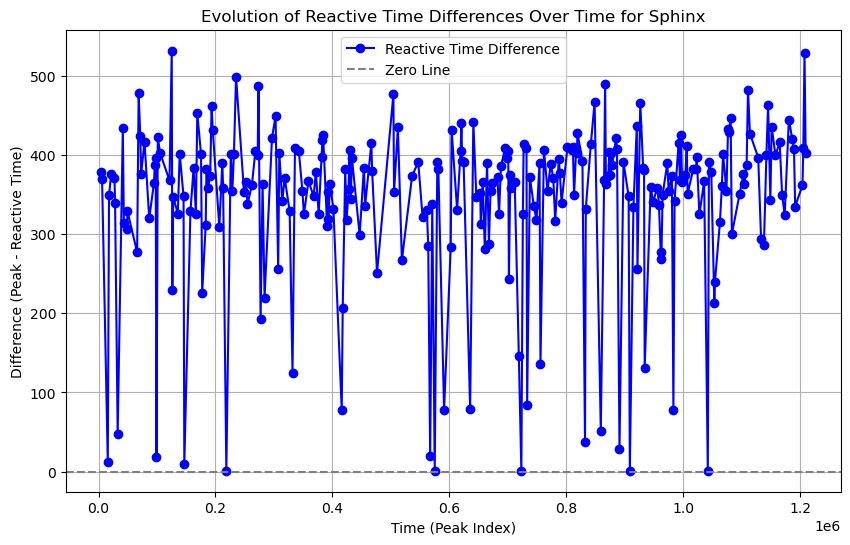

In [19]:
for i, key in enumerate(diff_dict.keys()):

    valid_indices = [i for i, diff in enumerate(diff_dict[key]) if diff is not None]
    valid_peaks = peaks_dict[key][valid_indices]
    valid_differences = np.array(diff_dict[key])[valid_indices]

    plt.figure(figsize=(10, 6))
    plt.plot(valid_peaks, valid_differences, marker='o', linestyle='-', color='b', label='Reactive Time Difference')
    plt.title(f'Evolution of Reactive Time Differences Over Time for {key}')
    plt.xlabel('Time (Peak Index)')
    plt.ylabel('Difference (Peak - Reactive Time)')
    plt.axhline(0, linestyle='--', color='gray', label='Zero Line')
    plt.legend()
    plt.grid()
    plt.show()

Result for HW1
ANOVA result: F-statistic = 3.093, p-value = 0.047
ANOVA: Significant differences found between intervals.


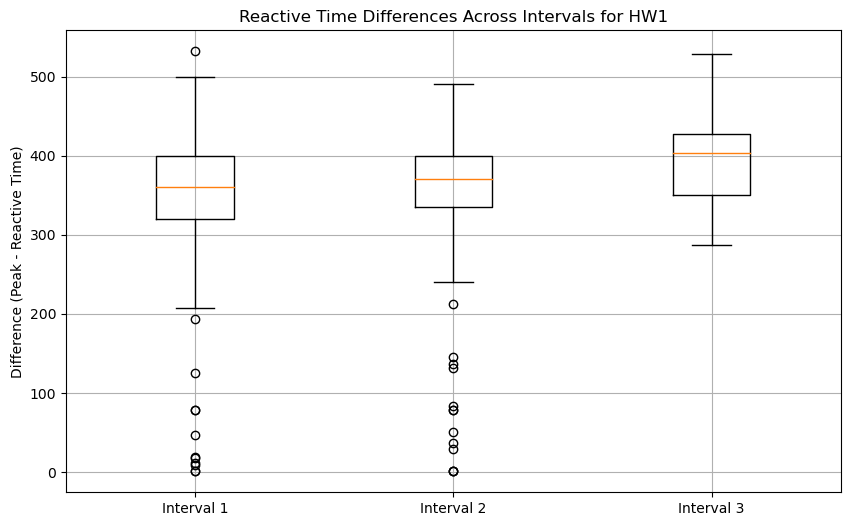

Result for HW4
ANOVA result: F-statistic = 2.672, p-value = 0.048
ANOVA: Significant differences found between intervals.


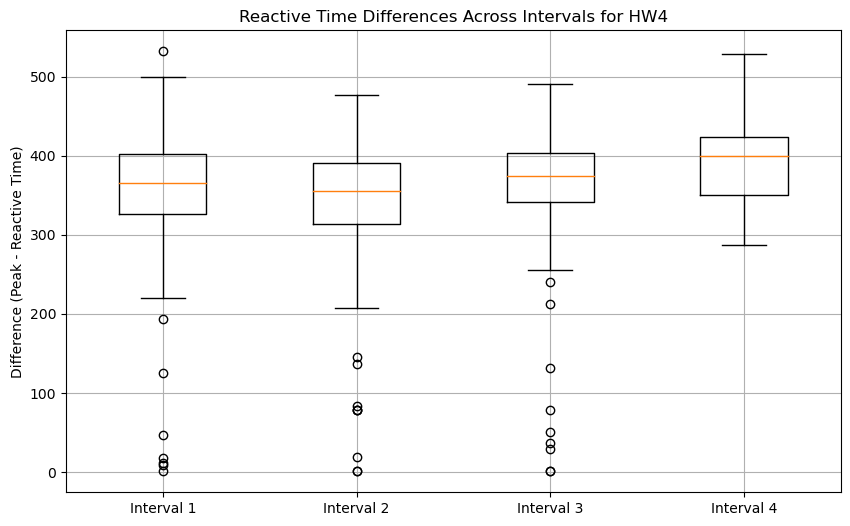

Result for Sphinx
ANOVA result: F-statistic = 0.862, p-value = 0.461
ANOVA: No significant differences between intervals.


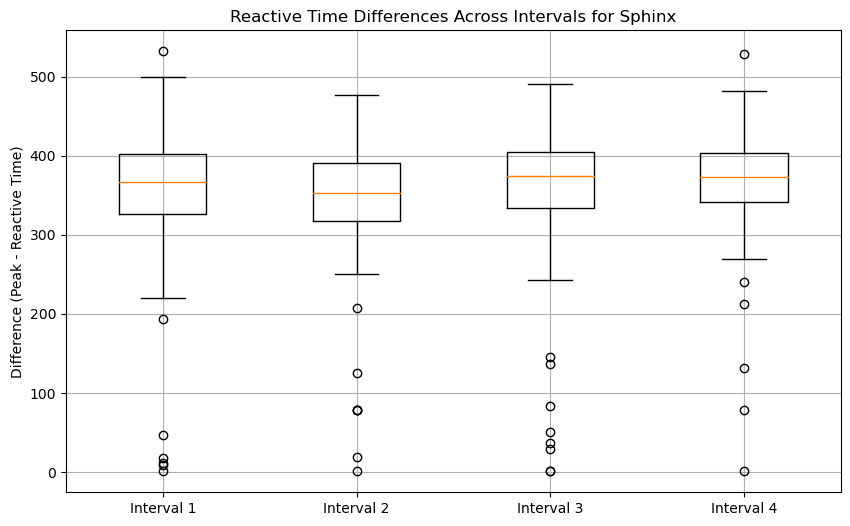

In [20]:
for i, key in enumerate(diff_dict.keys()):

    valid_indices = [i for i, diff in enumerate(diff_dict[key]) if diff is not None]
    valid_peaks = peaks_dict[key][valid_indices]

    num_intervals = 4
    interval_labels = np.arange(num_intervals)
    interval_edges = np.linspace(0, len(valid_peaks), num_intervals + 1, dtype=int)

    intervals = []
    for i in range(num_intervals):
        start, end = interval_edges[i], interval_edges[i + 1]
        intervals.append(valid_differences[start:end])

    intervals = [group for group in intervals if len(group) > 0]

    anova_result = f_oneway(*intervals)
    
    print(f'Result for {key}')
    print(f"ANOVA result: F-statistic = {anova_result.statistic:.3f}, p-value = {anova_result.pvalue:.3f}")

    if anova_result.pvalue < 0.05:
        print("ANOVA: Significant differences found between intervals.")
    else:
        print("ANOVA: No significant differences between intervals.")

    plt.figure(figsize=(10, 6))
    plt.boxplot(intervals, labels=[f"Interval {i+1}" for i in range(len(intervals))])
    plt.title(f'Reactive Time Differences Across Intervals for {key}')
    plt.ylabel('Difference (Peak - Reactive Time)')
    plt.grid()
    plt.show()

### Normalize and Align Calcium Data for all 3 animals

In [64]:
def z_score_normalize(data):
    return (data - np.mean(data)) / np.std(data)

def normalize_and_concat(calcium_dict):
    normalized_data = []
    
    for animal, data in calcium_dict.items():
        avg_roi = data.mean(axis=1).to_numpy()
        normalized_data.append(z_score_normalize(avg_roi))

    concatenated_array = np.concatenate(normalized_data)
    return concatenated_array


# Concatenate Calcium
concat_calcium = normalize_and_concat(calcium_dict)
print("Aligned and Concatenated Calcium array shape:", concat_calcium.shape)

# Concatenate Interpolated Calcium
concat_ca_interp = normalize_and_concat(ca_interp_dict)
print("Aligned and Concatenated Interpolated Calcium array shape:", concat_ca_interp.shape)

# Concatenate Breath
phase_all =[]
for animal, data in phase_peaks_dict.items():
    phase_all.append(data)
concat_phase = np.concatenate(phase_all)
print("Concatenated Sniff Phase array shape:", concat_phase.shape)

# Concatenate Stim
valve_all =[]
for animal, data in valve_dict.items():
    valve_all.append(data)
concat_valve = np.concatenate(valve_all)
print("Concatenated Valve array shape:", concat_valve.shape)


Aligned and Concatenated Calcium array shape: (53005,)
Aligned and Concatenated Interpolated Calcium array shape: (5320000,)
Concatenated Sniff Phase array shape: (5320000,)
Concatenated Valve array shape: (5320000,)


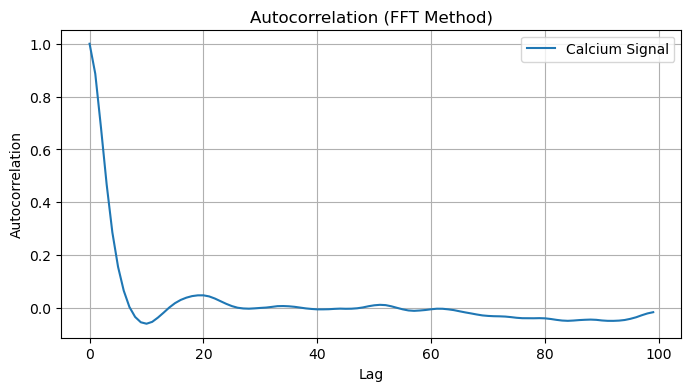

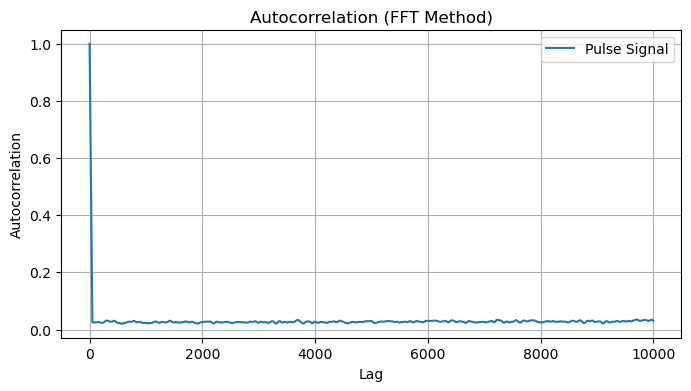

In [25]:

def perform_autocorrelation(signal):
    n = len(signal)
    # Zero-pad to the next power of 2 for efficient FFT
    n_padded = 2 ** (int(np.log2(n)) + 1)
    signal_fft = fft(signal, n=n_padded)
    autocorr = ifft(signal_fft * np.conj(signal_fft)).real  # Element-wise multiplication in Fourier space
    autocorr = autocorr[:n]  # Keep only the positive lags
    return autocorr / autocorr[0]  # Normalize by the maximum at lag 0

autocorr_ca = perform_autocorrelation(concat_calcium)
autocorr_valve = perform_autocorrelation(concat_valve)

plt.figure(figsize=(8, 4))
plt.plot(autocorr_ca[:100], label='Calcium Signal')
plt.title('Autocorrelation (FFT Method)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(autocorr_valve[:10000], label='Pulse Signal')
plt.title('Autocorrelation (FFT Method)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid()
plt.show()

### Repartition of stimulus

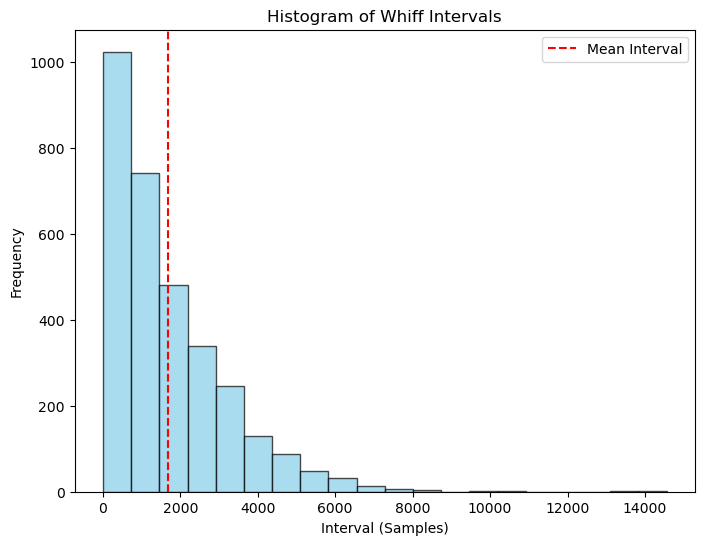

In [36]:
whiff_onsets = np.where(np.diff(concat_valve) > 0)[0]

# Calculate differences between consecutive whiff onsets
diffs = []
for i in range(1, len(whiff_onsets)):
    diff = whiff_onsets[i] - whiff_onsets[i-1]  # Corrected subtraction order
    diffs.append(diff)

# Create an x-axis for plotting
x = np.arange(len(diffs))  # Correct length of x-axis

plt.figure(figsize=(8, 6))
plt.hist(diffs, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Interval (Samples)')
plt.ylabel('Frequency')
plt.title('Histogram of Whiff Intervals')
plt.axvline(np.mean(diffs), color='red', linestyle='--', label='Mean Interval')
plt.legend()
plt.show()

Knowing that a stimulus triggers a response about 400-500 ms after it starts, if another stimulus starts before the previous one evokes a response, then there can be some response overlap of the 2 stimulus 

In [ ]:
close_diffs = [d for d in diffs if d < 500]
print("Close intervals (within 500 ms):", len(close_diffs))
print("Total number of events:", len(diffs))

Close intervals (less than 500 ms): 765
Total number of events: 3160


In [41]:
close_indices = []
for i in range(1, len(whiff_onsets)):
    diff = whiff_onsets[i] - whiff_onsets[i - 1]
    if diff < 500:
        close_indices.append(whiff_onsets[i - 1]) 
        close_indices.append(whiff_onsets[i])

print("Indices of close stimulus onsets (within 500 ms):", close_indices)

Indices of close stimulus onsets (within 500 ms): [10615, 10790, 21766, 21922, 31284, 31296, 33014, 33464, 41283, 41459, 76788, 76832, 76832, 77044, 88110, 88523, 88523, 88664, 92313, 92412, 100800, 100987, 100987, 101336, 122384, 122816, 151769, 151935, 151935, 152201, 158651, 158837, 168813, 169281, 176776, 177165, 179272, 179284, 184171, 184480, 199212, 199481, 203689, 203819, 214898, 214944, 215818, 216279, 224358, 224634, 226043, 226173, 232775, 232823, 238844, 238919, 247301, 247420, 247420, 247514, 251735, 251941, 267764, 267845, 267845, 267860, 285112, 285121, 285121, 285225, 293805, 293957, 293957, 294409, 294409, 294471, 302953, 303179, 317068, 317484, 317484, 317975, 327319, 327721, 329153, 329353, 331503, 331833, 331833, 332278, 343071, 343453, 352731, 353180, 367038, 367236, 371345, 371576, 378613, 378667, 383154, 383636, 387250, 387539, 392419, 392619, 407740, 407959, 407959, 408126, 408126, 408240, 408240, 408642, 418543, 418905, 418905, 419008, 426360, 426801, 436773, 4

In [ ]:
copy_concat_valve = concat_valve
for i in range(1, len(whiff_onsets)):
    diff = whiff_onsets[i] - whiff_onsets[i - 1]
    if diff < 500:
        copy_concat_valve[whiff_onsets[i]:whiff_onsets[i] + 51] = 0  # Set stimulus and 50 points after it to 0
new_whiff_onsets = np.where(np.diff(copy_concat_valve) > 0)[0]

close_indices = []
for i in range(1, len(new_whiff_onsets)):
    diff = new_whiff_onsets[i] - new_whiff_onsets[i - 1]
    if diff < 500:
        close_indices.append(new_whiff_onsets[i - 1]) 
        close_indices.append(new_whiff_onsets[i])

print("Indices of close stimulus onsets (within 500 ms):", close_indices)

Indices of close stimulus onsets (within 500 ms): []


In [74]:
def plot_valve_ca(concat_ca_interp, concat_valve, start_idx, end_idx):
    fig, ax1 = plt.subplots(figsize=(7, 4))

    t = np.arange(len(concat_ca_interp))

    ax1.plot(t[start_idx:end_idx], concat_ca_interp[start_idx:end_idx], color='tab:red', linewidth=2, label='Calcium')
    ax1.set_xlabel('Time (ms)', fontsize=12)
    ax1.set_ylabel('Calcium Imaging', color='tab:red', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.plot(t[start_idx:end_idx], concat_valve[start_idx:end_idx], color='tab:blue', linewidth=2, label='Valve')
    ax2.set_ylabel('Valve Pulse', color='tab:blue', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    ax1.grid(alpha=0.3)
    fig.tight_layout()

    plt.show()

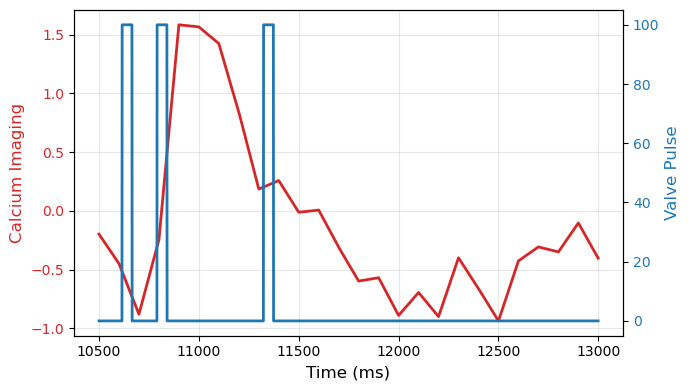

In [75]:
plot_valve_ca(concat_ca_interp, concat_valve, 10500, 13000)

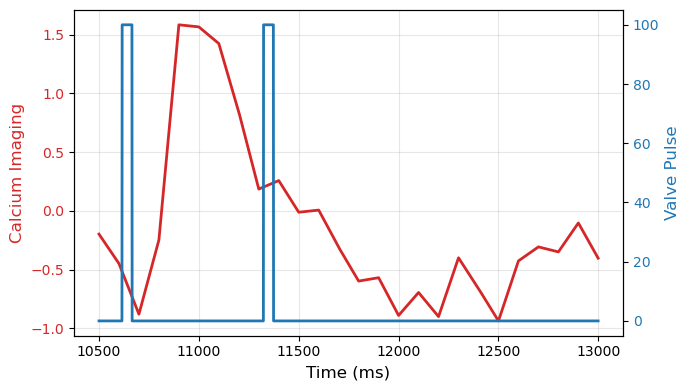

In [86]:
plot_valve_ca(concat_ca_interp, copy_concat_valve, 10500, 13000)

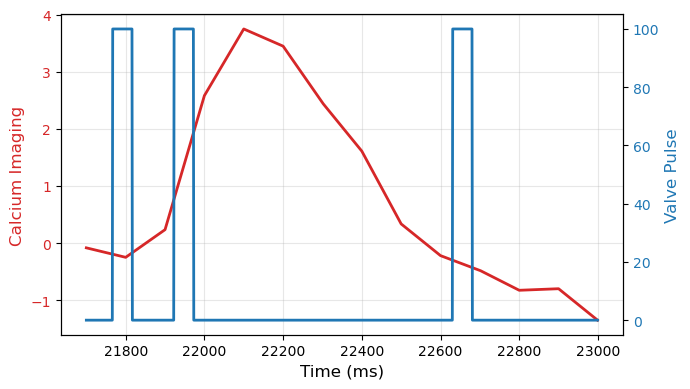

In [76]:
plot_valve_ca(concat_ca_interp, concat_valve, 21700, 23000)

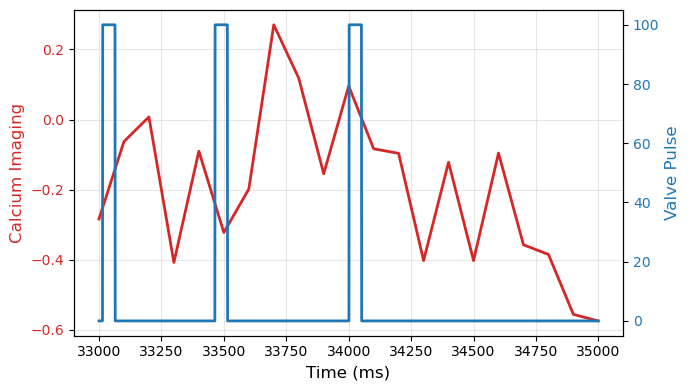

In [78]:
plot_valve_ca(concat_ca_interp, concat_valve, 33000, 35000)

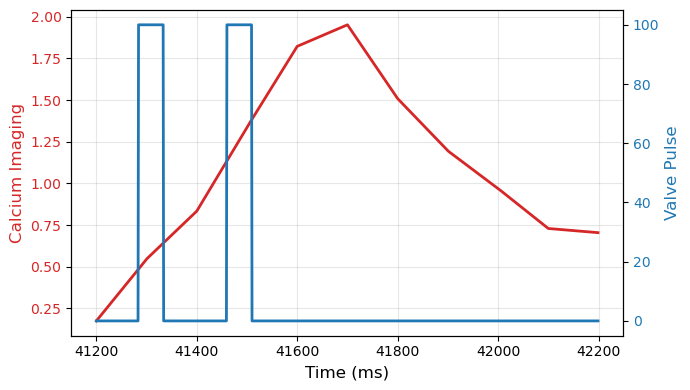

In [83]:
plot_valve_ca(concat_ca_interp, concat_valve, 41200, 42200)

In [115]:
window_size = 1000

phase_averages = []
for idx in close_indices:
    start = idx
    end = min(idx + window_size, len(concat_phase))
    avg_phase = np.mean(concat_phase[start:end])
    phase_averages.append(avg_phase)

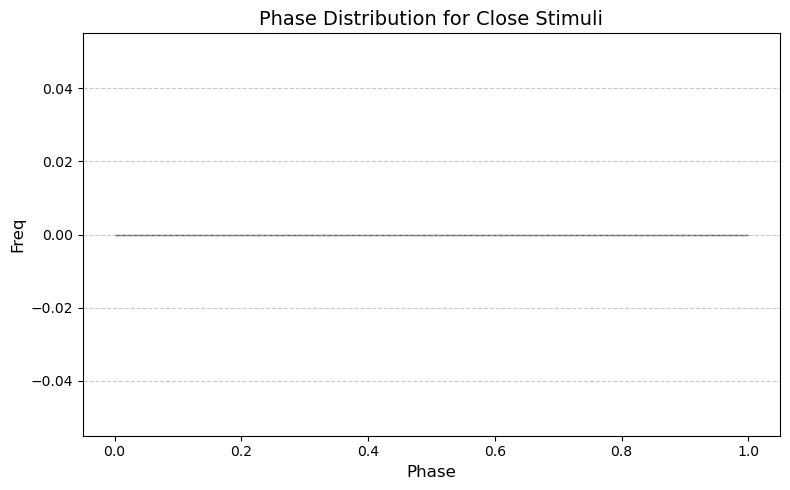

In [116]:

plt.figure(figsize=(8, 5))
plt.hist(phase_averages, bins=2, edgecolor='black', alpha=0.7)
plt.title('Phase Distribution for Close Stimuli', fontsize=14)
plt.xlabel('Phase', fontsize=12)
plt.ylabel('Freq', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


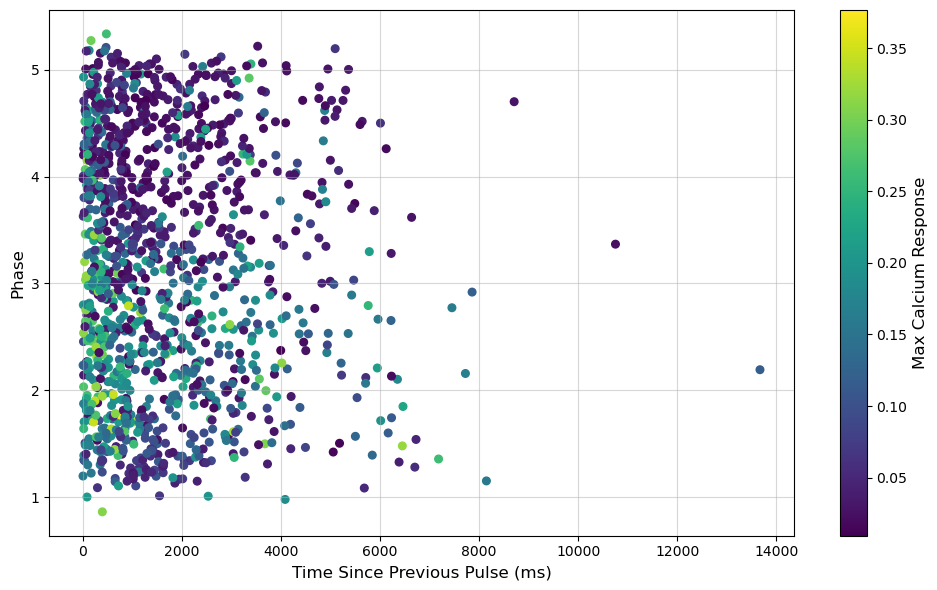

In [21]:
whiff_onsets = np.where(np.diff(valve_dict['HW1']) > 0)[0]

times_since_previous_pulse = []
phases = []
max_amplitudes = []

for i in range(1, len(whiff_onsets)):
    time_since_previous = whiff_onsets[i] - whiff_onsets[i - 1] # Time since previous pulse
    times_since_previous_pulse.append(time_since_previous) 

    start_idx = whiff_onsets[i]
    phase_value = np.mean(phase_peaks_dict['HW1'][start_idx:start_idx + 100])  # Mean phase in the 100 ms following pulse onset
    phases.append(phase_value)

    max_response = np.max(ca_interp_dict['HW1'][start_idx:start_idx + 600]) # Max calcium response in the 600 ms following the pulse onset
    max_amplitudes.append(max_response)

times_since_previous_pulse = np.array(times_since_previous_pulse)
phases = np.array(phases)
max_amplitudes = np.array(max_amplitudes)

plt.figure(figsize=(10, 6))
sc = plt.scatter(times_since_previous_pulse, phases, c=max_amplitudes, cmap='viridis', s=30) 

cbar = plt.colorbar(sc)
cbar.set_label('Max Calcium Response', fontsize=12)

plt.xlabel('Time Since Previous Pulse (ms)', fontsize=12)
plt.ylabel('Phase', fontsize=12)
#plt.title('Phase vs Time Since Previous Pulse with Calcium Response', fontsize=14)

plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()


Studies the calcium response to pulses depending on the phase at which the pulse occured and the time since a previous pulse has occured.